In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import numpy as np


In [8]:
df= pd.read_csv("/Users/snip/Documents/MEOP/20G_datagrab1.csv")
df.drop(columns=["Time - Voltage (Formula Result)","Polarization (%) - Voltage (Formula Result)"], inplace=True)
df.rename(columns={"Time - Voltage (Formula Result).1":"time","Polarization (%) - Voltage (Formula Result).1":"polarization"}, inplace=True)
df["time"] =pd.to_timedelta("00:"+df["time"])
df["time"] = df["time"].dt.total_seconds()
df

,time,polarization
0,398.7,5.40656
1,399.7,5.90808
2,400.8,5.08110
3,401.8,4.73898
4,402.9,5.73962
...,...,...
872,1314.0,4.19598
873,1315.0,4.00808
874,1316.1,4.45184
875,1317.1,3.73447


In [9]:


df["smoothed"] = savgol_filter(df["polarization"], 60, 3)

max_index = df["smoothed"].idxmax()
max_pol= df["smoothed"][max_index]
target_value=max_pol/np.e 
relaxation_data = df.iloc[max_index:]
relaxation_data=relaxation_data[relaxation_data["smoothed"]>target_value]
max_time=df["time"][max_index]
relaxation_time= relaxation_data["time"].iloc[-1]-max_time
print(f"Relaxation time: {relaxation_time} seconds")


Relaxation time: 129.19999999999993 seconds


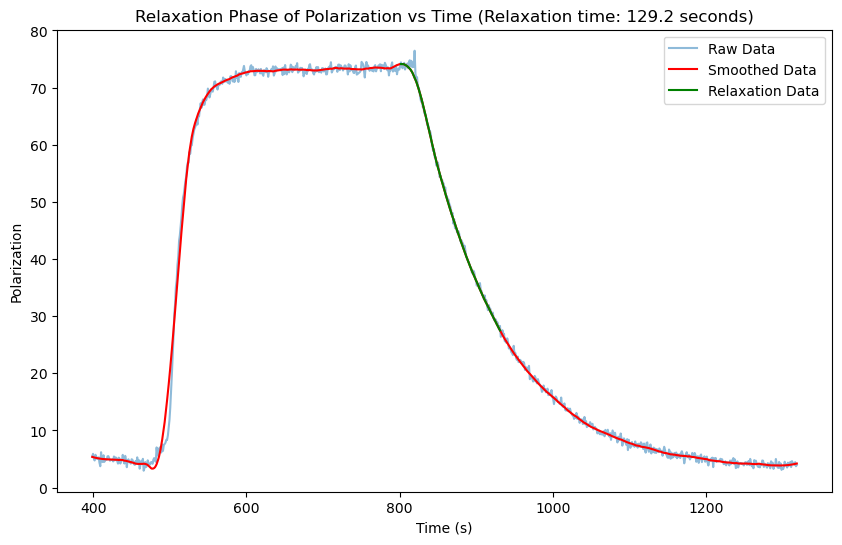

In [13]:
plt.figure(figsize=(10,6))
plt.plot(df["time"], df["polarization"], label="Raw Data", alpha=0.5)
plt.plot(df["time"], df["smoothed"], label="Smoothed Data", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Polarization")
plt.title("Polarization vs Time with Smoothing")
plt.legend()
plt.plot(relaxation_data["time"], relaxation_data["smoothed"], label="Relaxation Data", color='green')
plt.xlabel("Time (s)")
plt.ylabel("Polarization")      
plt.title(f"Relaxation Phase of Polarization vs Time (Relaxation time: {np.round(relaxation_time, 3)} seconds)")
plt.legend()
plt.show()

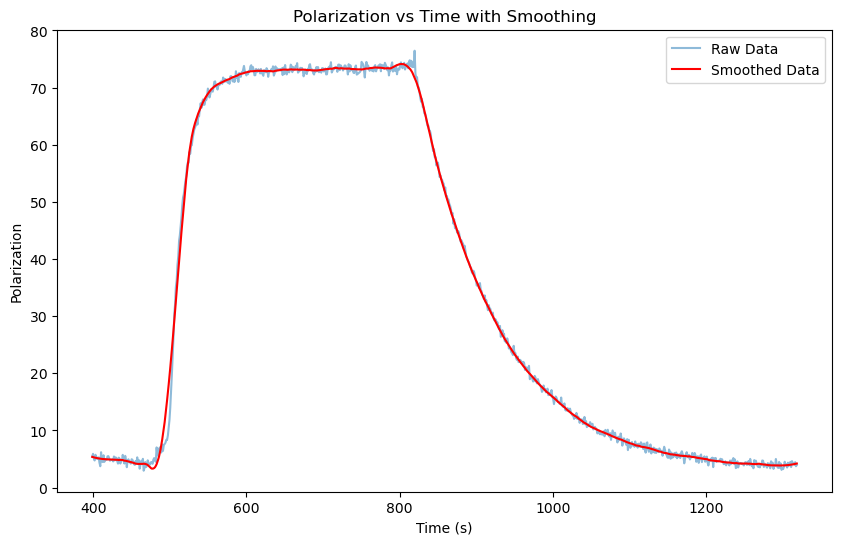

In [14]:
plt.figure(figsize=(10,6))
plt.plot(df["time"], df["polarization"], label="Raw Data", alpha=0.5)
plt.plot(df["time"], df["smoothed"], label="Smoothed Data", color='red')
plt.xlabel("Time (s)")
plt.ylabel("Polarization")
plt.title("Polarization vs Time with Smoothing")
plt.legend()
plt.show()